In [1]:
# Import working modules

import xarray as xr
import numpy as np
import scipy.stats as stats
import matplotlib
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import inspect, os, sys

# Suppress future warning of Python packages which only confuse you guys... I will (try to) keep it working
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Define paths
workingfolder = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))

if workingfolder.split('/')[-1] != 'Answers':
    Notebooks_path = os.path.join(workingfolder, 'Notebooks')
else:
    Notebooks_path = os.path.join(workingfolder, '..', 'Notebooks')

# adding path of notebooks to sys.path
if Notebooks_path not in sys.path:
    sys.path.append(Notebooks_path)
import core_pp
import func_SPI

matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['legend.fontsize'] = 'large'

**Action**: Make sure that you define to the correct path and file in the code-box below. If needed, make changes to input_folder and input_file. Afterwards run the code by pressing *shift+enter*.

In [2]:
inputfolder   = os.path.join(workingfolder,'..', 'Data')

# Name input file
precip_file   = os.path.join(inputfolder,'p_1979-2018_Africa.nc')
country_codes = os.path.join(inputfolder,'Africa_mask_Countries.nc')
sst_Pacific   = os.path.join(inputfolder,'sst_1979-2018_ENSO_region.nc')

## 2: Loading Precipitation and Potential Evaporation data

You will now start with loading and inspecting the input data within Python Jupyter Notebooks. You will do this in the following code-box. Press *ctrl+enter* to run the code.

**Action**: Load the data into the memory of this kernel.

In [3]:
precip_m  = core_pp.import_ds_lazy(precip_file)

sorting longitude
sorting latitude


In [4]:
precip = precip_m * 1000
precip.name = 'Precipitation [mm/day]'
precip.attrs['units'] = '[mm/day]'

### 2b: Retrieve land_sea_mask from country_codes
First we will focus on quantifying drought in Kenya. In order to retrieve only data from that country, we load the 'country_codes'.

**Action**: Load country_codes and select precipiation and evaporation of Kenya. 

In [5]:
country = xr.open_dataset(country_codes).country_mask
land_sea_mask = country >= 1

# Calculate ENSO 3.4 index

### 3a: Calculating a spatial mean
When calculating a spatial mean, one has to take into account that the earth is round, 
meaning that the equally spaced gridboxes do not represent equal surfaces of the earth. Admittendly, it will not matter much for countries close to the equator, but it is the neat thing to do. The function to take into account the differences in gridbox sizes is defined in the next cell.

In [6]:
def area_weighted(xarray):
   # Area weighted, taking cos of latitude in radians     
    coslat = np.cos(np.deg2rad(xarray.coords['latitude'].values)).clip(0., 1.)
    area_weights = np.tile(coslat[..., np.newaxis],(1,xarray.longitude.size))
    area_weights = area_weights / area_weights.mean()
    return xr.DataArray(xarray.values * area_weights, coords=xarray.coords, 
                          dims=xarray.dims)

With xarray, we can easily select the dimensions over which we want to do a computation. Thus for calculating the spatial mean we simply typ:

In [7]:
sst_enso  = core_pp.import_ds_lazy(sst_Pacific, format_lon='only_east')

Enso_34_raw = area_weighted(sst_enso).mean(dim=('latitude','longitude'))



In [8]:
Enso_34_all = (Enso_34_raw - Enso_34_raw.mean() ) / Enso_34_raw.std() 

Cell below calculates SPI for each land grid point, this costs quite some computational power. You can simply open the file that is already stored in the Data (input_folder). 

In [9]:
# SPI_aggregation = 6
# precip_Africa = precip.where(land_sea_mask)
# SPI_xr = func_SPI.calc_SPI_from_daily(precip_Africa, SPI_aggregation, freq='months')
# filepath = os.path.join(inputfolder, 'SPI-6_Africa_monthly.nc')
# SPI_xr.to_netcdf(filepath)

**Action**: Load in the SPI_Africa_file in the cell below

In [10]:
# Remove
SPI_Africa_file = os.path.join(inputfolder, 'SPI-6_Africa_monthly.nc')
SPI_6_Africa = core_pp.import_ds_lazy(SPI_Africa_file)

sorting longitude
sorting latitude


The cell below calculated the correlation coefficient and p-value for each gridpoint.

**Action**: Make a function out the the cell below.

In [11]:
SPI_xr = SPI_6_Africa

Enso_34   = Enso_34_all.sel(time=SPI_xr.time) # select matching dates
mask = SPI_xr['mask']
output = SPI_xr['mask'].copy().astype(float)
sign = SPI_xr['mask'].copy().astype(float)
output_np = np.zeros_like(SPI_xr['mask'], dtype='float32')
sign_np = np.zeros_like(SPI_xr['mask'], dtype='float32')
latitude = SPI_xr.latitude
longitude =SPI_xr.longitude
lats,lons = np.meshgrid(latitude, longitude)
latlon = (np.swapaxes(lats,1,0)[mask.values], np.swapaxes(lons,1,0)[mask.values])
n_gs = len(np.swapaxes(lats,1,0)[mask.values])
coords = [(latlon[0][i],latlon[1][i]) for i in range(n_gs)]
for lat, lon in coords:
    r, p = stats.pearsonr(Enso_34,SPI_xr.sel(latitude=lat, longitude=lon))
    lat_idx = int(np.argwhere(latitude.values==lat)[0])
    lon_idx = int(np.argwhere(longitude.values==lon)[0])
    output_np[lat_idx, lon_idx] = r
    sign_np[lat_idx, lon_idx] = p
output.values = output_np
sign.values = sign_np

sign = sign.where(sign['mask'])

**Action**: Make nice plot of output, try to add information which gridcells are significantly correlated (by stippling or contour lines, or simply masking all non-significant gridcells).

(see other notebook for details)

/Users/semvijverberg/miniconda3/envs/ivm_github/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/semvijverberg/miniconda3/envs/ivm_github/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/semvijverberg/miniconda3/envs/ivm_github/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/semvijverberg/miniconda3/envs/ivm_github/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = oth

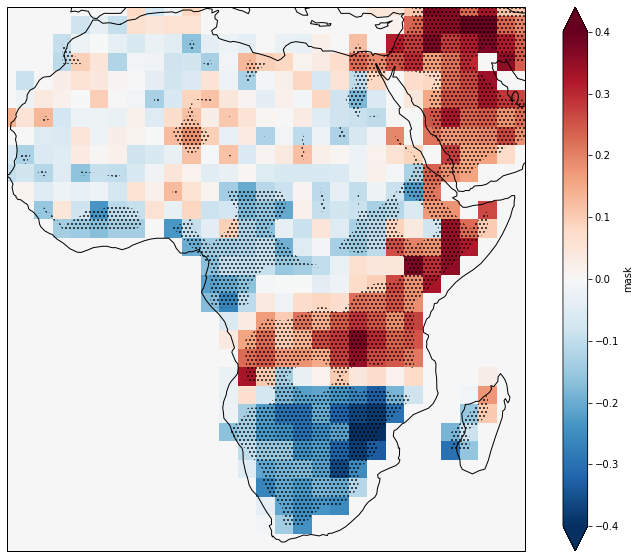

In [12]:
# figure 3
map_proj = ccrs.PlateCarree(central_longitude=10)

fig = plt.figure(figsize=(30,10) )

# plot precipitation
ax1 = plt.subplot(1, 2, 1, projection=map_proj)
colormap = plt.cm.RdBu_r
output.plot(ax=ax1, transform=ccrs.PlateCarree(), 
                             subplot_kws={'projection': map_proj},
                             cmap=colormap,
                            vmin=-0.4, vmax=0.4)

sign.plot.contourf(ax=ax1, levels=[0, 0.05, 1],
           transform=ccrs.PlateCarree(), hatches=['...', ''],
           colors='none', add_colorbar=False,
           subplot_kws={'projection': map_proj})

ax1.coastlines()


**Question 9**: Interpret the spatial map with correlation coefficients.

**Bonus Action**: Create a correlation plot for each seperate season. Tip: use SPI_xr['time.season']


In [39]:
# Type you code here. Tip: use the function you just created.

**Bonus Bonus Action**: plot the SPI for each season during El Nino and La Nina years

The official definition is that a 3 month running mean of the ENSO 3.4 timeseries should be above (or below) 0.5 degrees Celcius. To make life easy, I'm also fine if you only select the dates that are above or below 1 degree Celcius.

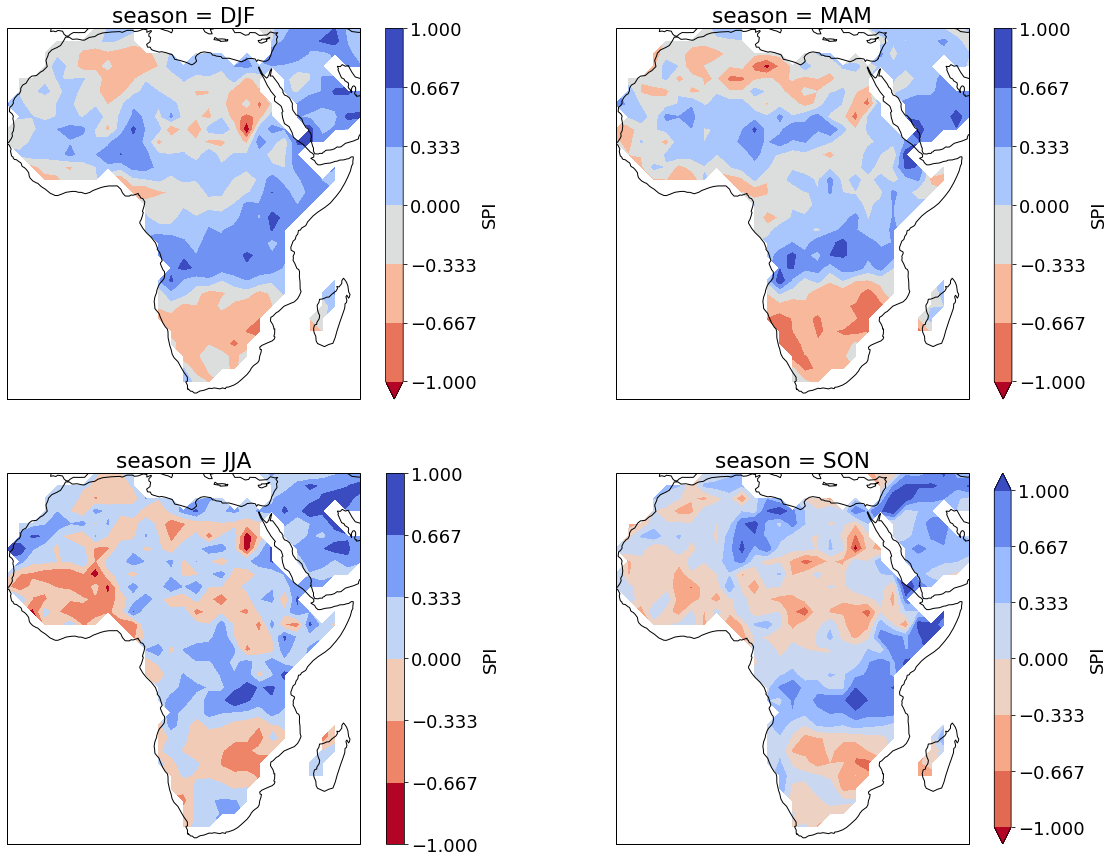

In [40]:
ENSO_rm3 = Enso_34_all.rolling(time=91, center=False, min_periods=1).mean()

mask_ENSO = ENSO_rm3 > 1
ENSO_dates = pd.to_datetime(mask_ENSO[mask_ENSO].time.values)
# match to SPI dates
ENSO_SPI = pd.to_datetime([d for d in SPI_xr.time.values if d in ENSO_dates])


SPI_seasons = SPI_xr.sel(time=ENSO_SPI).groupby('time.season').mean('time')
SPI_seasons.name = 'SPI'
SPI_seasons = SPI_seasons.where(land_sea_mask)

map_proj = ccrs.PlateCarree(central_longitude=10)
colormap = plt.cm.coolwarm_r
plt.figure(figsize=(20,15))
for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    ax = plt.subplot(2, 2, i+1, projection=map_proj)
    SPI_seasons.sel(season=season).plot.contourf(ax=ax,
                                                 transform=ccrs.PlateCarree(), 
                                                 subplot_kws={'projection': map_proj},
                                                cmap=colormap,
                                                vmin=-1, vmax=1)
    ax.coastlines()